In [1]:
from tqdm import tqdm
import os

import PIL
from PIL import Image
import numpy as np
import json
import torch
from torch.utils.data import Dataset, DataLoader
import itertools
from torchvision import datasets, transforms, models
from einops import rearrange
from itertools import product
import math
import torchvision.models as models
import argparse
import torchvision
import random
random_seed=777
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

/data/jong980812/anaconda3/envs/asd/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model  

In [2]:
path = '/data/jong980812/project/mae/result_after_shapley/asd/no_binary_224_168_/OUT/'
#01/checkpoint-29.pth'
padding_mode='zeros'
model_pool = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for split in ['01','02','03','04','05']:
    weight = os.path.join(path,split,'checkpoint-29.pth')
    model=models.efficientnet_b1(pretrained=True,progress=False)
    model.classifier[1] = torch.nn.Linear(1280, 2)
    for name, layer in model.named_modules():
        if isinstance(layer, torch.nn.Conv2d):
            layer.padding_mode = padding_mode
    # load model    
    checkpoint = torch.load(weight, map_location='cpu')
    print("Load pre-trained checkpoint from: %s" % weight)
    checkpoint_model = checkpoint['model']
    state_dict = model.state_dict()
    msg = model.load_state_dict(checkpoint_model, strict=False)
    model.to(device)
    model.eval()
    print(msg)
    model_pool[split]=model
print(device)

Load pre-trained checkpoint from: /data/jong980812/project/mae/result_after_shapley/asd/no_binary_224_168_/OUT/01/checkpoint-29.pth
<All keys matched successfully>
Load pre-trained checkpoint from: /data/jong980812/project/mae/result_after_shapley/asd/no_binary_224_168_/OUT/02/checkpoint-29.pth
<All keys matched successfully>
Load pre-trained checkpoint from: /data/jong980812/project/mae/result_after_shapley/asd/no_binary_224_168_/OUT/03/checkpoint-29.pth
<All keys matched successfully>
Load pre-trained checkpoint from: /data/jong980812/project/mae/result_after_shapley/asd/no_binary_224_168_/OUT/04/checkpoint-29.pth
<All keys matched successfully>
Load pre-trained checkpoint from: /data/jong980812/project/mae/result_after_shapley/asd/no_binary_224_168_/OUT/05/checkpoint-29.pth
<All keys matched successfully>
cpu


# Datasets

In [3]:
import pandas as pd
class Shapley_part_asd(Dataset):
    def __init__(self, data_folder, anno_path,json_folder, transform=None):
        self.json_folder = json_folder
        self.data_folder = data_folder
        self.transform = transform
        # self.image_paths = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.gif'))]
        self.anno_path = anno_path
        df = pd.read_csv(self.anno_path,header=None,delimiter=' ')
        self.image_paths = df.values[:,0].tolist()
        self.label_list = df.values[:,1].tolist()
        self.json_paths = [image_path.split('/')[-1].split('.')[0] + ".json" for image_path in self.image_paths] #! Get json path from image paths.
        self.split = [str(image_path.split('/')[-4]) for image_path in self.image_paths] #! Get json path from image paths.
        # print(self.image_paths)
    def __repr__(self) -> str:
        number = len(self.image_paths)
        return f'Shapley Part Dataset class\nData Num:{number}'
    def get_part_json(self, json_file_path):
        '''
        Get part dictionary from json path
        '''
        part_json = {}
        part_name = ['nose','mouth','ear','hand','head','hair','foot','upper_body','lower_body','face','eye']
        with open(json_file_path, 'r') as f:
            boxes = json.load(f)['shapes']
            for part in part_name:
                part_json[part]=[]
            for box in boxes:
                part_json[box["label"]].append(box["points"])
    
        for key in part_json:#! 빈 애들은 None으로 처리해서 없다고 판단.
            if not part_json[key]:
                part_json[key] = None

        return part_json
    def get_coords(self, part):
        extracted_coordinates = []
        if part is None:
            return None
        elif len(part) == 1:
            # print(part[0][0])
            xmin, ymin = list(map(int,part[0][0]))
            xmax, ymax = list(map(int,part[0][1]))
            return [[xmin,ymin,xmax,ymax]]#아래 2일경우와 통일하기 위해 이중 리스트로 
        elif len(part) == 2:
            #! Eye, Ear, hand, foot -> These have 2 part, return list
            for a in part: 
                # print(a)
                xmin, ymin = list(map(int,a[0]))
                xmax, ymax = list(map(int,a[1]))
                extracted_coordinates.append([xmin,ymin,xmax,ymax])
            return extracted_coordinates
        else:
            for a in part: 
                # print(a)
                xmin, ymin = list(map(int,a[0]))
                xmax, ymax = list(map(int,a[1]))
                extracted_coordinates.append([xmin,ymin,xmax,ymax])
            return extracted_coordinates
    def get_white_image(self,size,pixel=(255,255,255)):
        return Image.new("RGB", size,pixel) #(int(pixel[0]), int(pixel[1]), int(pixel[2])))
    # def get_only_hair(self,img,part_imgs,part_json):
    #     head_coords = self.get_coords(part_json['head'])
    #     head = part_imgs['head'][0]#!
    #     hair_coords = self.get_coords(part_json['hair'])
    #     hair = part_imgs['hair'][0]#!
    #     face_coords = self.get_coords(part_json['face'])
    #     face = part_imgs['face'][0]
    #     neck_coords = self.get_coords(part_json['neck'])
    #     neck = part_imgs['neck'][0]
    #     white_image = self.get_white_image(img.size)
    #     white_image.paste(hair,hair_coords[0])
    #     white_image.paste(self.get_white_image(face.size),face_coords[0])
    #     white_image.paste(self.get_white_image(neck.size),neck_coords[0])
    #     return white_image.crop(hair_coords[0]), [[hair_coords[0][0],hair_coords[0][1]],[hair_coords[0][2],hair_coords[0][3]]]
    # def get_only_face(self,img,part_imgs,part_json):
    #     face_coords = self.get_coords(part_json['face'])
    #     face = part_imgs['face'][0]

    #     white_image = self.get_white_image(img.size)
    #     white_image.paste(face,face_coords[0])

    #     for part in ['eye','nose','mouth','ear']:
    #                 if part_json[part] is not None:
    #                     part_coords= self.get_coords(part_json[part])
    #                     part_img = part_imgs[part]
    #                     for i in range(len(part_img)):
    #                         white_image.paste(self.get_white_image(part_img[i].size),part_coords[i])
    #     return white_image.crop(face_coords[0]), [[face_coords[0][0],face_coords[0][1]],[face_coords[0][2],face_coords[0][3]]]
    def get_empty_face(self,img, part_imgs, part_json):
        '''
        head: 머리카락포함, 어꺠밑에 내려와있는 머리까지.
        만약에 머리카락이 손가락까지 내려와있으면, 
        '''
        head_coords = self.get_coords(part_json['head'])
        head = part_imgs['head'][0]#!
        
        white_image = self.get_white_image(img.size)
        white_image.paste(head,head_coords[0])

        for part in ['eye','nose','mouth','ear']:
            if part_json[part] is not None:
                part_coords= self.get_coords(part_json[part])
                part_img = part_imgs[part]
                for i in range(len(part_img)):
                    white_image.paste(self.get_white_image(part_img[i].size),part_coords[i])
        #! uppper body랑 loower 바디까지 빼버리기 
            #   if part in ['eye','ear']:   
            #       white_image.paste(self.get_white_image(part_img[0].size),part_coords[0])
            #       white_image.paste(self.get_white_image(part_img[1].size),part_coords[1])
            #   else:
            #       white_image.paste(self.get_white_image(part_img[0].size),part_coords[0])
        # white_image.show()

            
        return white_image.crop(head_coords[0]), [[head_coords[0][0],head_coords[0][1]],[head_coords[0][2],head_coords[0][3]]]
    def get_empty_upper_body(self,img, part_imgs, part_json):
        '''
        1. 백지에 몸통 붙이기
        2. 양 팔 붙이고 손떼기
        3. 새로운 upperbody 좌표 규정.
        '''
        white_image = Image.new("RGB", img.size, (255, 255, 255))
        upper_body_json = part_json['upper_body']
        upper_body_coords = self.get_coords(upper_body_json)
        upper_body = part_imgs['upper_body'][0]#!
        white_image.paste(upper_body,upper_body_coords[0])


        # white_image.paste(left_hand,hand_coords[0])
        # white_image.paste(right_hand,hand_coords[1])
        if part_json["hand"] is not None:
            part_coords= self.get_coords(part_json["hand"])
            part_img = part_imgs["hand"]
            for i in range(len(part_img)):
                white_image.paste(Image.new("RGB", part_img[i].size, (255, 255, 255)),part_coords[i])
        
        return white_image.crop(upper_body_coords[0]), [[upper_body_coords[0][0],upper_body_coords[0][1]],[upper_body_coords[0][2],upper_body_coords[0][3]]]

    def get_empty_lower_body(self,img, part_imgs, part_json):
        '''
        empty_lower_body detacched foot
        leg 두개를 빈 도화지에 붙이고 발을 뗀뒤 empty lower body로 규정.
        '''
        white_image = self.get_white_image(img.size)
        lower_body_json = part_json['lower_body']
        lower_body_coords = self.get_coords(lower_body_json)
        lower_body = part_imgs['lower_body'][0]#!
        white_image.paste(lower_body,lower_body_coords[0])
            # white_image.paste(leg_img[i],leg_coords[i])
        # for i,pocket in enumerate(part_imgs['pocket']):
        #     # pocket.show()
        #     white_image.paste(pocket,pocket_coords[i])
        # white_image.show()
        if part_json["foot"] is not None:
            part_coords= self.get_coords(part_json["foot"])
            part_img = part_imgs["foot"] 
            for i in range(len(part_img)):
                white_image.paste(Image.new("RGB", part_img[i].size, (255, 255, 255)),part_coords[i])
        # white_image.crop(lower_body_coords).show()
        return white_image.crop(lower_body_coords[0]),[[lower_body_coords[0][0],lower_body_coords[0][1]],[lower_body_coords[0][2],lower_body_coords[0][3]]]

    
    def create_new_images(self,img, binary_combination, part_imgs,part_json,avg_pixel):
        #! Making New images
        original_img = img
        empty_face_active, eye_active, nose_active, ear_active, mouth_active, hand_active, foot_active = binary_combination
        new_image = img.copy()

        #! Original image에서 Lower body, Upperbody빼고 모두 없앰.
        if (part_json["empty_face"] is not None):#empty face를 떼는코드.
            for i in range(len(part_imgs['empty_face'])):
                new_image.paste(self.get_white_image(part_imgs['empty_face'][i].size,avg_pixel),self.get_coords(part_json['empty_face'])[i])
        new_image.paste(part_imgs["empty_upper_body"][0], self.get_coords(part_json['empty_upper_body'])[0])  # 원하는 위치에 붙임
        new_image.paste(part_imgs["empty_lower_body"][0], self.get_coords(part_json['empty_lower_body'])[0])  # 원하는 위치에 붙임
        if (part_json["eye"] is not None):
            for i in range(len(part_imgs['eye'])):
                new_image.paste(self.get_white_image(part_imgs['eye'][i].size,avg_pixel),self.get_coords(part_json['eye'])[i])
        if (part_json["nose"] is not None):
            for i in range(len(part_imgs['nose'])):
                new_image.paste(self.get_white_image(part_imgs['nose'][i].size,avg_pixel),self.get_coords(part_json['nose'])[i])
        if (part_json["ear"] is not None):
            for i in range(len(part_imgs['ear'])):
                new_image.paste(self.get_white_image(part_imgs['ear'][i].size,avg_pixel),self.get_coords(part_json['ear'])[i])
        if (part_json["mouth"] is not None):
            for i in range(len(part_imgs['mouth'])):
                new_image.paste(self.get_white_image(part_imgs['mouth'][i].size,avg_pixel),self.get_coords(part_json['mouth'])[i])
        if (part_json["hand"] is not None):
            for i in range(len(part_imgs['hand'])):
                new_image.paste(self.get_white_image(part_imgs['hand'][i].size,avg_pixel),self.get_coords(part_json['hand'])[i])
        if (part_json["foot"] is not None):
            for i in range(len(part_imgs['foot'])):
                new_image.paste(self.get_white_image(part_imgs['foot'][i].size,avg_pixel),self.get_coords(part_json['foot'])[i]) 
        # new_image = self.get_white_image(img.size)
        # new_image.paste(part_imgs["empty_upper_body"][0], self.get_coords(part_json['empty_upper_body'])[0])  # 원하는 위치에 붙임
        # new_image.paste(part_imgs["empty_lower_body"][0], self.get_coords(part_json['empty_lower_body'])[0])  # 원하는 위치에 붙임

          
        #!######
        
        if empty_face_active:
            # new_image.paste(part_imgs["empty_face"][0],self.get_coords(part_json['empty_face'])[0])
            new_image.paste(part_imgs["empty_face"][0],self.get_coords(part_json['empty_face'])[0])
        
            
        # 각 파트 이미지를 읽어와서 새로운 이미지에 붙임
        if eye_active and (part_json["eye"] is not None):
            for i in range(len(part_imgs["eye"])):
                new_image.paste(part_imgs["eye"][i], self.get_coords(part_json['eye'])[i])  # 원하는 위치에 붙임
        if nose_active and (part_json["nose"] is not None):
            for i in range(len(part_imgs["nose"])):
                new_image.paste(part_imgs["nose"][i], self.get_coords(part_json['nose'])[i])  # 원하는 위치에 붙임
        if ear_active and (part_json["ear"] is not None):
            for i in range(len(part_imgs["ear"])):
                new_image.paste(part_imgs["ear"][i], self.get_coords(part_json['ear'])[i])  # 원하는 위치에 붙임
        if mouth_active and (part_json["mouth"] is not None):
            for i in range(len(part_imgs["mouth"])):
                new_image.paste(part_imgs["mouth"][i], self.get_coords(part_json['mouth'])[i])  # 원하는 위치에 붙임
        if hand_active and (part_json["hand"] is not None):
            for i in range(len(part_imgs["hand"])):
                new_image.paste(part_imgs["hand"][i], self.get_coords(part_json['hand'])[i])  # 원하는 위치에 붙임
        if foot_active and (part_json["foot"] is not None):
            for i in range(len(part_imgs["foot"])):
                new_image.paste(part_imgs["foot"][i], self.get_coords(part_json['foot'])[i])  # 원하는 위치에 붙임
        # 다른 파트들에 대해서도 같은 방식으로 처리
        return new_image
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        # print(img_path)
        # label = 0 if self.image_paths[0].split('/')[-1].split('-')[0]=='A' else 1
        label = self.label_list[idx]
        image = Image.open(img_path)
        original_image=image.copy()
        
        new_image_array =np.array(image)
        avg_pixel = tuple(np.uint8(np.mean(image,(0,1))))
        split = self.split[idx]
        # if self.binary_thresholding:
            # image = image.convert("L")#! Convert grayscale
            # image = image.point(lambda p: p > self.binary_thresholding and 255)
        part_json = self.get_part_json(os.path.join(self.json_folder,self.json_paths[idx]))#! 존재하는 모든 part에 대해서 불러옴.
        part_imgs = {}
        for part in part_json.keys():#모든 part를 잘라서 다시 dict으로 리턴하기위함.
            part_imgs[part]=[]
            coords = self.get_coords(part_json[part])
            if coords is None:
                part_imgs[part].append(None)    
            # elif len(coords) ==1:
            #     part_imgs[part].append(image.crop(coords[0]))    
            # elif len(coords) == 2:
            #     part_imgs[part].append(image.crop(coords[0]))    
            #     part_imgs[part].append(image.crop(coords[1]))
            else:
                for i in range(len(coords)):
                    part_imgs[part].append(image.crop(coords[i]))    
        # empty_face.show()
        empty_upper_body, empty_upper_body_coords = self.get_empty_upper_body(image,part_imgs,part_json)
        empty_lower_body, empty_lower_body_coords= self.get_empty_lower_body(image,part_imgs,part_json)
        empty_face , empty_face_coords= self.get_empty_face(image,part_imgs,part_json)
        # only_hair, only_hair_coords = self.get_only_hair(image,part_imgs,part_json)
        # only_face, only_face_coords = self.get_only_face(image,part_imgs,part_json)
        part_imgs['empty_face']=[empty_face]
        part_json['empty_face']=[empty_face_coords]
        part_imgs['empty_lower_body']=[empty_lower_body]
        part_json['empty_lower_body']=[empty_lower_body_coords]
        part_imgs['empty_upper_body']=[empty_upper_body]
        part_json['empty_upper_body']=[empty_upper_body_coords]#좌표 바뀌어서 넣어줘야함.
        
        part_combinations = list(itertools.product([0, 1], repeat=7))
        new_imgs = []
        # print(part_json)
        for combination in part_combinations:
            # print(combination)
            new_img=self.create_new_images(img=image,binary_combination=combination, part_imgs=part_imgs,part_json=part_json,avg_pixel=avg_pixel)
            if self.transform:
                new_img=self.transform(new_img)#.expand(3,-1,-1)
            new_imgs.append(new_img.unsqueeze(0))
        new_imgs = torch.cat(new_imgs,dim=0)
        # image = self.transform(image)
        # image_3ch = image.expand(3,-1,-1)
        return new_imgs, self.transform(original_image), label ,img_path, split

# Transform

In [4]:
from shapley.transform import ThresholdTransform
transform_asd=transforms.Compose([
    transforms.Resize((224,168)),
    # transforms.Grayscale(3),
    transforms.ToTensor(),
    # ThresholdTransform(240),
    # transforms.Normalize(mean=[0.98, 0.98, 0.98],
    #                         std=[0.06, 0.06, 0.06])
    transforms.Normalize(mean=[0.96, 0.96, 0.96],
                            std=[0.1, 0.1, 0.1])
    ])

# Check image

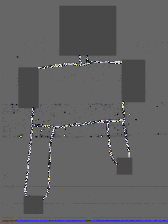

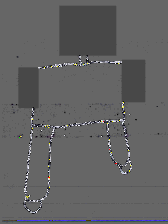

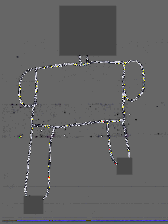

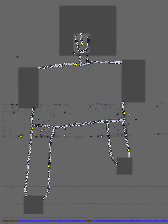

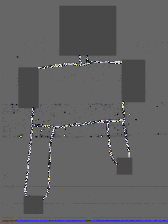

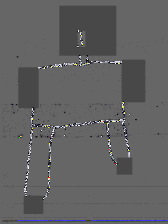

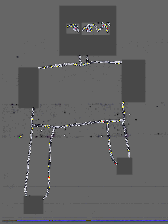

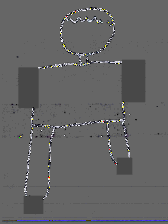

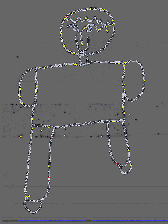

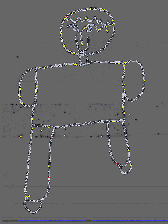

In [5]:
check_dataset = Shapley_part_asd('dataset/TD/','/data/jong980812/project/part_shapley/dataset/ASD/asd.csv','dataset/json/',transform=transform_asd)
topil = transforms.ToPILImage()
for i in [0,1,2,4,8,16,32,64,127]:
    topil(check_dataset[1][0][i]).show()
topil(check_dataset[1][1])
# image_array = np.array(a)
# tuple(np.mean(image_array,(0,1)))


# Visualizer

In [6]:
import matplotlib.pyplot as plt
import os
import json
from PIL import Image
import random

def shapley_class(part,part_count, task, class_name, num_correct, nb_data, save_path):
    plt.clf()
    data2={}
    for i in range(7):
        data2[part[i]]=(list(part_count.values())[i])/nb_data
    # {0: 1139, 1: 5, 2: 3, 3: 47, 4: 5, 5: 5, 6: 2}
    # 딕셔너리의 key와 value를 각각 리스트로 추출
    x = list(data2.keys())
    y = list(data2.values())

    # 그래프 생성
    plt.bar(x, y)

    # x축과 y축에 라벨 추가
    plt.xlabel('x')
    plt.ylabel('y')

    # 그래프 제목 추가
    # plt.title(f'{num_correct}/{len(dataset)}={num_correct/len(dataset)*100}%')
    plt.title(f'{task} task  : {class_name} samples\n{num_correct}/{nb_data}={num_correct/nb_data*100:.2f}%')
    # 그래프 표시
    plt.savefig(os.path.join(save_path,f'{task}_{class_name}.png'))
    plt.show()
    
    
def shapley_task(part,part_count_list, task, class_name, num_correct, nb_data, save_path):
    plt.clf()
    data2={}
    for part_name in part:
        data2[part_name]=0
    for i in range(7):
        value=0
        for part_count in part_count_list:
            value+=(list(part_count.values())[i])
        data2[part[i]]=value / nb_data
    # {0: 1139, 1: 5, 2: 3, 3: 47, 4: 5, 5: 5, 6: 2}
    # 딕셔너리의 key와 value를 각각 리스트로 추출
    x = list(data2.keys())
    y = list(data2.values())

    # 그래프 생성
    plt.bar(x, y)

    # x축과 y축에 라벨 추가
    plt.xlabel('x')
    plt.ylabel('y')

    # 그래프 제목 추가
    # plt.title(f'{num_correct}/{len(dataset)}={num_correct/len(dataset)*100}%')
    plt.title(f'{task} task total  : \n{num_correct}/{nb_data}={num_correct/nb_data*100:.2f}%')
    # 그래프 표시
    plt.savefig(os.path.join(save_path,f'{task}_total.png'))
    plt.show()

def representative_each_class(shapley_lists, best_part_list,task, class_names, json_path, n_show,save_path):
    '''
    shapley_list: shapley value and path of all images
    task: Task name
    class names: all class name
    json path: json path to get part information
    '''
    num_class = len(class_names)
    part=['Empty_face',"Eye","Nose","Ear","Mouth","Hand","Foot"]

    for class_index, class_name in enumerate(class_names):
        plt.clf()
        fig, axes = plt.subplots(num_class, n_show, figsize=(12, 10))
        plotting_order = [i for i, _ in enumerate(class_names) if i != class_index]
        best_part = best_part_list[class_name]
        shapley_list = shapley_lists[class_name]
        #가장 큰 값의 key value pair  tuple
        sorted_shapley_dict = {k: v for k, v in sorted(shapley_list.items(), key=lambda item: item[1][best_part],reverse=True)} 
        sorted_shapley_list=list(sorted_shapley_dict.keys())[:n_show]
        for i in range(num_class):
            for j in range(n_show):
                if i==0:#beset
                    axes[i, j].imshow(Image.open(sorted_shapley_list[j]),cmap='gray')#(get_humna_body(sorted_shapley_list[j],json_path), cmap='gray')
                    axes[i, j].axis('off')
                else:
                    img_list=shapley_lists[class_names[plotting_order[i-1]]]#another class imig lists
                    random_key = random.choice(list(img_list.keys()))
                    axes[i, j].imshow(Image.open(random_key),cmap='gray') #(get_humna_body(random_key,json_path), cmap='gray')
                    axes[i, j].axis('off')
        for i in range(num_class):        
            if i ==0:
                axes[i, 0].set_title(f'Best {class_name} - {part[best_part]}', fontsize=30,ha='center')
            else:
                axes[i, 0].set_title(f'{class_names[plotting_order[i-1]]} - {part[best_part]}', fontsize=30)
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.savefig(os.path.join(save_path,f'{task}_{class_name}_{part[best_part]}_vs_another.png'))
        plt.show()

def get_humna_body(image_path,json_path):
    json_full_path =os.path.join(json_path, image_path.split('/')[-1].split('.')[0] + ".json")
    part_json = get_part_json(json_full_path)
    human_body_coords =get_coords(part_json['human_body'])
    img = Image.open(image_path)
    return img.crop(human_body_coords[0]).resize((300,400))
    
    
def get_part_json(json_file_path):
    '''
    Get part dictionary from json path
    '''
    part_json = {}
    with open(json_file_path, 'r') as f:
        boxes = json.load(f)['shapes']
        for box in boxes:
            part_json[box["label"]]=[]
        for box in boxes:
            part_json[box["label"]].append(box["points"])

    for key in part_json:#! 빈 애들은 None으로 처리해서 없다고 판단.
        if not part_json[key]:
            part_json[key] = None

    return part_json
def get_coords(part):
    extracted_coordinates = []
    if part is None:
        return None
    elif len(part) == 1:
        # print(part[0][0])
        xmin, ymin = list(map(int,part[0][0]))
        xmax, ymax = list(map(int,part[0][1]))
        return [[xmin,ymin,xmax,ymax]]#아래 2일경우와 통일하기 위해 이중 리스트로 
    elif len(part) == 2:
        #! Eye, Ear, hand, foot -> These have 2 part, return list
        for a in part: 
            # print(a)
            xmin, ymin = list(map(int,a[0]))
            xmax, ymax = list(map(int,a[1]))
            extracted_coordinates.append([xmin,ymin,xmax,ymax])
        return extracted_coordinates
    else:
        for a in part: 
            # print(a)
            xmin, ymin = list(map(int,a[0]))
            xmax, ymax = list(map(int,a[1]))
            extracted_coordinates.append([xmin,ymin,xmax,ymax])
        return extracted_coordinates

ASD는 바이너리하면 잘안돼요. 성능이 구림 90도 안나옴. 240 250 220, 


# Shapley


#####################Target_class:ASD getting Shapley value#####################
Shapley Part Dataset class
Data Num:50


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:31<00:00,  1.61it/s]

Shapley result
:{0: 28, 1: 12, 2: 0, 3: 6, 4: 0, 5: 2, 6: 0}
Inference
:48/50 = 0.96


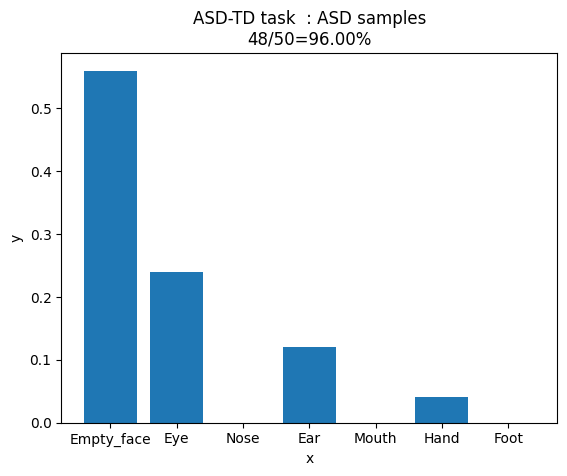


#####################Target_class:TD getting Shapley value#####################
Shapley Part Dataset class
Data Num:50


100%|██████████| 50/50 [00:09<00:00,  5.28it/s]

Shapley result
:{0: 31, 1: 0, 2: 0, 3: 0, 4: 5, 5: 6, 6: 3}
Inference
:45/50 = 0.9


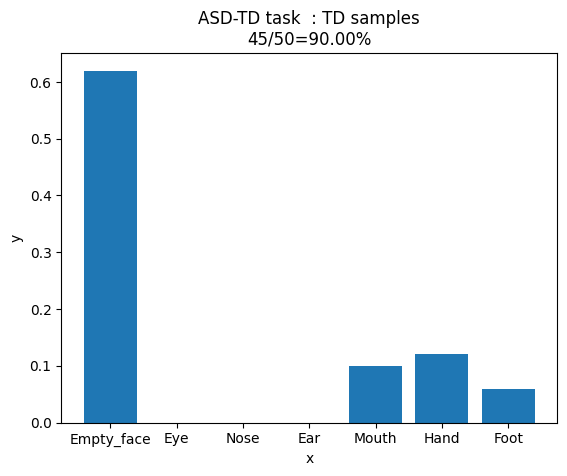

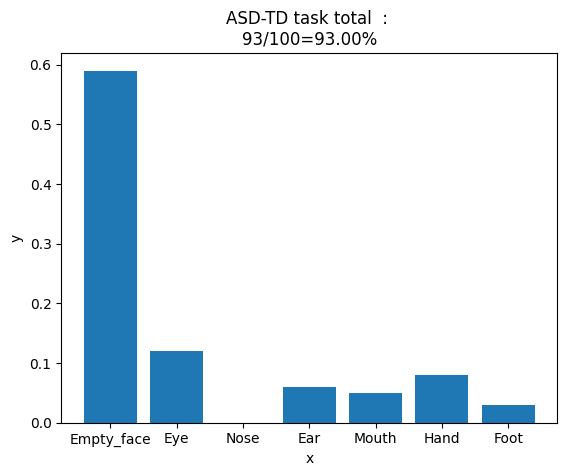

<Figure size 640x480 with 0 Axes>

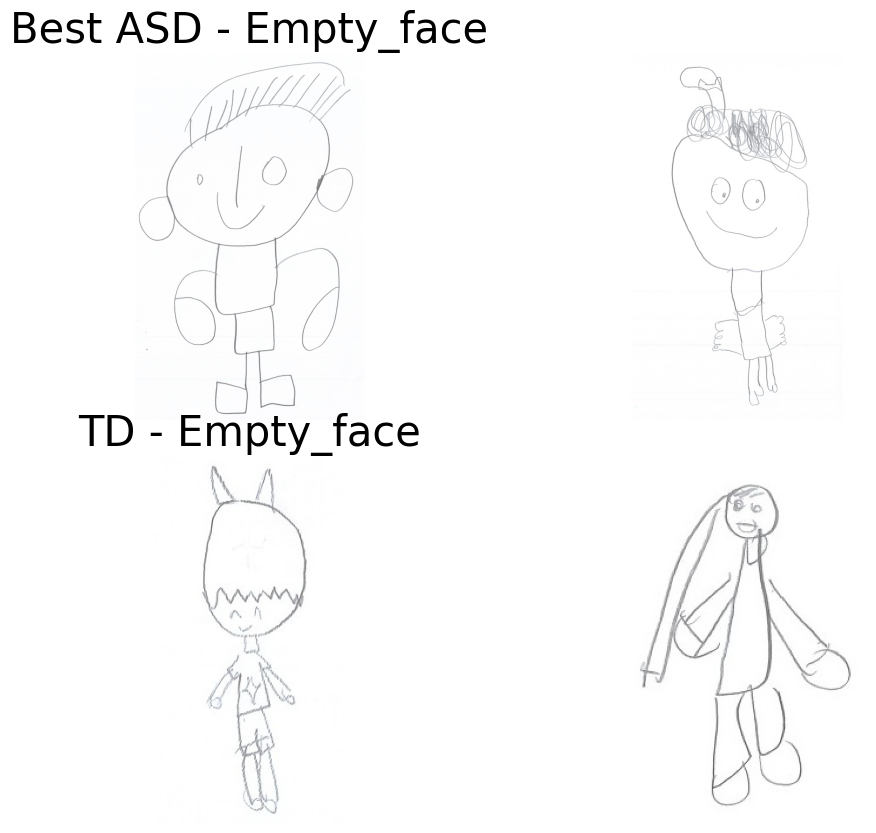

<Figure size 640x480 with 0 Axes>

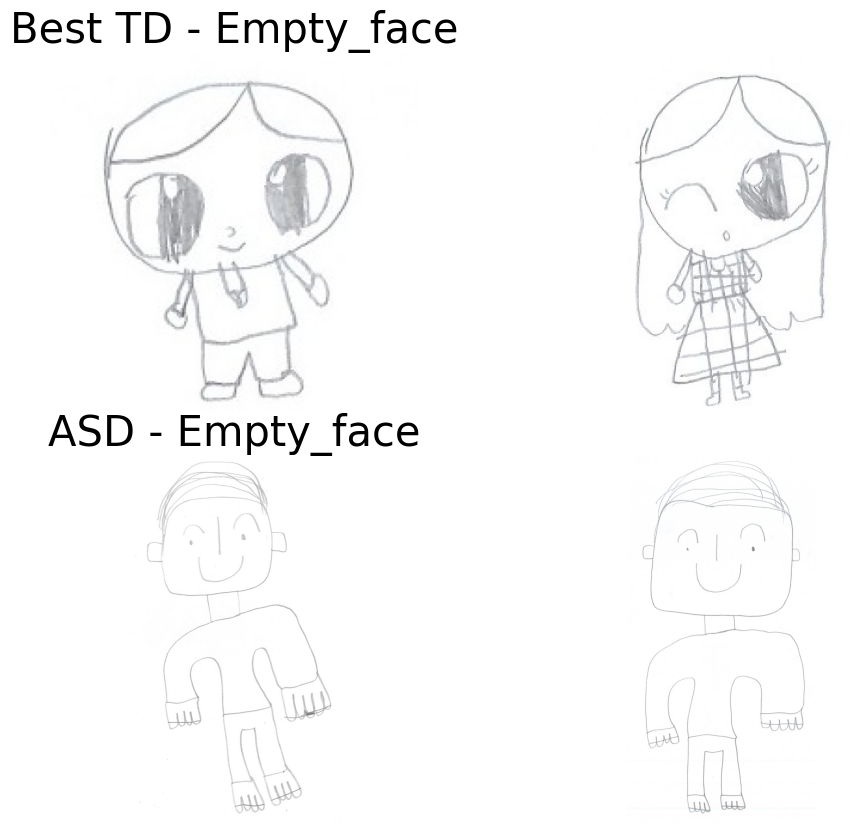

In [7]:
from shapley.get_shapley_value import *
all_ordered_pair,weights = get_ordered_pair()
# Collect each class result
part_count_list = []
nb_data_list = []
num_correct_list = []
part_number = all_ordered_pair.shape[0]
shapley_img_lists=dict()
best_part_index = dict()
class_names = ['ASD','TD']
data_path = 'dataset'
json_path = 'dataset/json'
task = 'ASD-TD'
save_path = 'dataset'
asd_dataset = Shapley_part_asd('','/data/jong980812/project/part_shapley/dataset/ASD/asd.csv',json_path,transform=transform_asd)
td_dataset = Shapley_part_asd('','/data/jong980812/project/part_shapley/dataset/ASD/td.csv',json_path,transform=transform_asd)

for class_name in class_names:
    print(f'\n#####################Target_class:{class_name} getting Shapley value#####################')
    target_path = os.path.join(data_path, class_name)
    dataset = asd_dataset if class_name=='ASD' else td_dataset
    data_loader=DataLoader(dataset,1,shuffle=False,num_workers=8)
    print(dataset)
    num_correct = 0
    part_count = {i: 0 for i in range(part_number)}
    image_and_shapley=dict()
    for new_imgs, original_image, label,img_paths,split in tqdm(data_loader):
        # print(new_imgs.shape)
        input_data = new_imgs
        # print('complete')
        batch_size = input_data.shape[0]
        input_data = rearrange(input_data,  'b t c h w -> (b t) c h w')
        
        # model.to(device)
        input_data = input_data.to(device)
        original_image = original_image.to(device)
        label = label.to(device)

        with torch.no_grad():
            prediction = model_pool[split[0]](original_image)
            output = model_pool[split[0]](input_data)

        output = rearrange(output, '(b t) o -> b t o', b=batch_size) # batch_size, 128, output(2)
        prediction = prediction.argmax(dim=-1)
        # print(output.shape)
        # print(label)
        for i in range(batch_size):
            if prediction[i] == label[i]:
                num_correct +=1
                img_name = img_paths[i]
                correct_output = output[:,:,label[i]]# Take correct logits,  (b, 128), 밖에서. 
                shapley_matrix = get_shapley_matrix(all_ordered_pair,correct_output[i])
                shapley_contributions = shapley_matrix[:,:,1] - shapley_matrix[:,:,0] 
                shapley_value = (shapley_contributions * 1/weights).sum(dim=1)
                image_and_shapley[img_name]=shapley_value.detach().tolist()
                max_part_number = (int(shapley_value.argmax()))
                part_count[max_part_number] += 1
    shapley_img_lists[class_name]=image_and_shapley
    best_part_index[class_name] = max(part_count, key=part_count.get)
    acc = num_correct/len(dataset)
    print(f'Shapley result\n:{part_count}')
    print(f'Inference\n:{num_correct}/{len(dataset)} = {acc}')
    # 주어진 딕셔너리
    part=['Empty_face',"Eye","Nose","Ear","Mouth","Hand","Foot"]
    num_correct_list.append(num_correct)
    part_count_list.append(part_count) # For Total shapley
    nb_data_list.append(len(dataset)) # For Total shapley
    shapley_class(
                part = part, 
                part_count= part_count, 
                task= task,
                class_name = class_name,
                num_correct=num_correct,
                nb_data=len(dataset),
                save_path=save_path)
shapley_task(
            part = part, 
            part_count_list= part_count_list, 
            task= task,
            class_name = class_name,
            num_correct=sum(num_correct_list),
            nb_data=sum(nb_data_list),
            save_path=save_path)
representative_each_class(shapley_lists=shapley_img_lists,
                            best_part_list=best_part_index,
                            task=task,
                            class_names=class_names,
                            n_show=2,
                            save_path=save_path,
                            json_path=json_path)

In [25]:
for class_name in class_names:
    print(f'\n#####################Target_class:{class_name} getting Shapley value#####################')


#####################Target_class:ASD getting Shapley value#####################

#####################Target_class:TD getting Shapley value#####################


In [3]:
import csv
import os
data_path = '/data/datasets/asd/All_5split/'
td_path = '/data/datasets/asd/All_5split/'
with open('asd_td_val.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    for split in ['01','02','03','04','05']:
        split_path = os.path.join(data_path,split,'val')
        asd_path = os.path.join(split_path,'ASD')
        td_path = os.path.join(split_path,'TD')
    # 리스트의 각 항목을 한 줄씩 CSV 파일에 쓰기
        for item in os.listdir(asd_path):
            writer.writerow([f'{os.path.join(asd_path,item)} 0'])
        for item in os.listdir(td_path):
            writer.writerow([f'{os.path.join(td_path,item)} 1'])